# 1. PREDIKSI HARGA BITCOIN 30-90 HARI KEDEPAN MENGGUNAKAN LINEAR REGRETION DAN LSTM
#### - Nama: Ro;if Hakim Febriansyah
#### - NIM: A11.2023.14936
#### - Kelompok: A11.4406
#### - Mata Kuliah: Pembelajaran Mesin
#### - Dosen Pengampu: Abu Salam M.kom

### 2. Ringkasan dan Permasalahan Project
Proyek ini bertujuan memprediksi harga Bitcoin (BTC) dengan mempertimbangkan hubungan antar variabel makroekonomi seperti indeks saham (S&P500), emas, dolar (DXY), volatilitas pasar (VIX), dan yield obligasi (TNX).

### Permasalahan
- Bagaimana pengaruh faktor makro terhadap pergerakan harga BTC?
- Sejauh mana model machine learning dapat memprediksi harga BTC 1–3 bulan ke depan?

### Tujuan
- Menganalisis hubungan antar variabel makro dan harga BTC.
- Melakukan prediksi harga BTC dalam jangka pendek (1–3 bulan).

### Alur Penyelesaian:

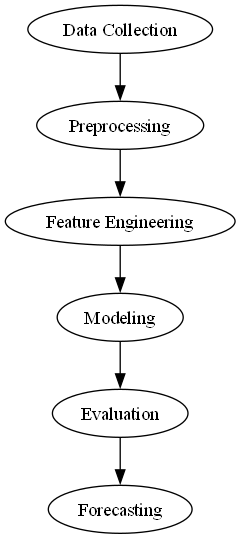

In [8]:
from graphviz import Digraph
from IPython.display import Image

# Buat flowchart
dot = Digraph()
dot.node('A', 'Data Collection')
dot.node('B', 'Preprocessing')
dot.node('C', 'Feature Engineering')
dot.node('D', 'Modeling')
dot.node('E', 'Evaluation')
dot.node('F', 'Forecasting')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Tampilkan langsung di Jupyter
Image(dot.pipe(format='png'))


### 3. Penjelasan Dataset, EDA, dan Pembentukan Fitur

#### 📁 Deskripsi Dataset

Dataset yang digunakan mencakup data harga penutupan harian dari berbagai aset ekonomi global dari tahun **2018 hingga April 2025**. Tujuan utama dari dataset ini adalah untuk memprediksi harga **Bitcoin (BTC)** berdasarkan indikator-indikator makroekonomi yang memiliki potensi pengaruh terhadap pasar kripto.

#### 🔍 Fitur yang Digunakan

- **BTC_Close** : Harga penutupan Bitcoin
- **SNP_Close** : Harga indeks S&P 500 (pasar saham AS)
- **Gold_Close** : Harga logam mulia emas
- **DXY_Close** : Indeks kekuatan Dolar AS
- **VIX_Close** : Indeks volatilitas (indikator ketakutan pasar)
- **TNX_Close** : Yield obligasi pemerintah AS tenor 10 tahun

#### 🎯 Target Prediksi

- **BTC_Close** (nilai di masa depan)
  
Target yang ingin diprediksi adalah harga penutupan Bitcoin berdasarkan fitur-fitur ekonomi di atas.

---

#### 🧪 Langkah EDA dan Pembentukan Fitur

##### 1. Memuat dan Menyelaraskan Data
- Seluruh dataset disatukan berdasarkan kolom `Date`
- Kolom `Close` dari tiap aset diubah menjadi nama spesifik (contoh: `BTC_Close`)
- Format tanggal dikonversi dan dijadikan index (`pd.to_datetime`)

##### 2. Visualisasi Tren Aset
- Data divisualisasikan menggunakan `matplotlib` untuk membandingkan tren antara Bitcoin dan aset makro lainnya.
- Tujuan: melihat apakah pergerakan harga Bitcoin memiliki pola yang searah, berlawanan, atau tidak terhubung dengan aset lain.

##### 3. Korelasi Antar Fitur
- Menggunakan `sns.heatmap(df.corr())` untuk menilai kekuatan hubungan antar variabel
- Hasil korelasi membantu pemilihan fitur yang relevan untuk modeling
- Beberapa fitur seperti `SNP_Close` dan `DXY_Close` menunjukkan hubungan korelatif terhadap `BTC_Close`

##### 4. Feature Engineering (Pembuatan Fitur Tambahan)
Fitur tambahan ditambahkan untuk memberikan konteks historis terhadap model:
- `BTC_Lag1`  : Harga BTC satu hari sebelumnya (lag)
- `BTC_MA7`   : Rata-rata harga BTC 7 hari terakhir
- `BTC_MA30`  : Rata-rata harga BTC 30 hari terakhir

##### 5. Pembersihan Data
- Menghapus baris yang mengandung `NaN` akibat moving average
- Data diurutkan berdasarkan waktu agar tetap sesuai dengan urutan time series

##### 6. Pemilihan Fitur dan Target
- **Fitur (X):**  
  `'BTC_Lag1'`, `'BTC_MA7'`, `'BTC_MA30'`, `'SNP_Close'`, `'Gold_Close'`, `'DXY_Close'`, `'VIX_Close'`, `'TNX_Close'`
- **Target (y):**  
  `'BTC_Close'`

##### 7. Normalisasi (Jika Diperlukan)
- Untuk model seperti LSTM atau XGBoost, dilakukan normalisasi fitur menggunakan **MinMaxScaler**
- Untuk model linear regression sederhana, normalisasi opsional namun dapat membantu kestabilan model

---

Hasil EDA menunjukkan bahwa faktor-faktor ekonomi global memiliki hubungan yang cukup signifikan terhadap pergerakan harga Bitcoin, dan fitur-fitur tersebut layak untuk dimasukkan ke dalam model prediksi.


#### 🧰 Import Library Utama (Final)

In [2]:
# Data Handling & Analisis
import pandas as pd
import numpy as np

# Visualisasi Statis
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi Interaktif
import plotly.express as px
import plotly.graph_objs as go  # untuk plotly manual

# Preprocessing & Evaluasi Model
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Deep Learning (LSTM, dll)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# XGBoost Model (jika digunakan)
from xgboost import XGBRegressor

# Analisis Teknikal
import ta  # pastikan install: pip install ta

# Handling waktu
import datetime

# Save & Load Model (opsional)
import pickle

# Sistem & Warning
import os
import warnings
warnings.filterwarnings("ignore")


#### Menggabungkan semua data dan memasukan menjadi 1 file

In [9]:
btc = pd.read_csv('btc.csv')
snp = pd.read_csv('sp500.csv')
gold = pd.read_csv('gold.csv')
dxy = pd.read_csv('dxy.csv')
vix = pd.read_csv('vix.csv')
tnx = pd.read_csv('tnx.csv')

# Rename kolom agar seragam
btc = btc[['Date', 'Close']].rename(columns={'Close': 'BTC_Close'})
snp = snp[['Date', 'Close']].rename(columns={'Close': 'SNP_Close'})
gold = gold[['Date', 'Close']].rename(columns={'Close': 'Gold_Close'})
dxy = dxy[['Date', 'Close']].rename(columns={'Close': 'DXY_Close'})
vix = vix[['Date', 'Close']].rename(columns={'Close': 'VIX_Close'})
tnx = tnx[['Date', 'Close']].rename(columns={'Close': 'TNX_Close'})

# Gabungkan semuanya berdasarkan 'Date'
df = btc.merge(snp, on='Date')
df = df.merge(gold, on='Date')
df = df.merge(dxy, on='Date')
df = df.merge(vix, on='Date')
df = df.merge(tnx, on='Date')

# Simpan gabungan ke file CSV baru (opsional tapi disarankan)
df.to_csv("data_gabungan.csv", index=False)


#### Menampilkan data yang sudah di gabungkan

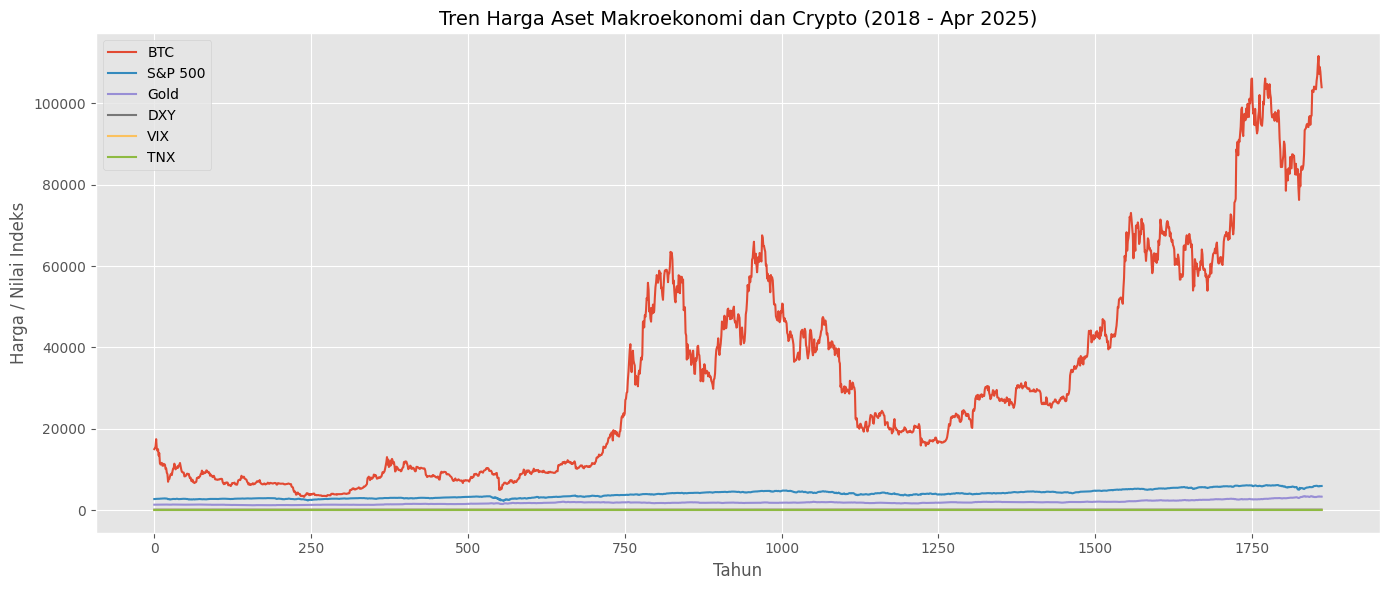

In [5]:
# Set style
plt.style.use('ggplot')  # atau 'classic', 'bmh', dll
plt.figure(figsize=(14, 6))

# Plot semua aset
plt.plot(df['BTC_Close'], label='BTC')
plt.plot(df['SNP_Close'], label='S&P 500')
plt.plot(df['Gold_Close'], label='Gold')
plt.plot(df['DXY_Close'], label='DXY')
plt.plot(df['VIX_Close'], label='VIX')
plt.plot(df['TNX_Close'], label='TNX')

# Formatting
plt.title('Tren Harga Aset Makroekonomi dan Crypto (2018 - Apr 2025)', fontsize=14)
plt.xlabel('Tahun')
plt.ylabel('Harga / Nilai Indeks')
plt.legend()
plt.tight_layout()
plt.show()

#### Mengurutkan data berdasarkan tanggal

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')


#### Feature Engineering dan Pembersihan Data

In [11]:
df['BTC_Lag1'] = df['BTC_Close'].shift(1)
df['BTC_MA7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_MA30'] = df['BTC_Close'].rolling(window=30).mean()

# Drop baris yang mengandung NaN karena moving average dan lag
df = df.dropna()


### Menampilkan Korelasi antar Fitur

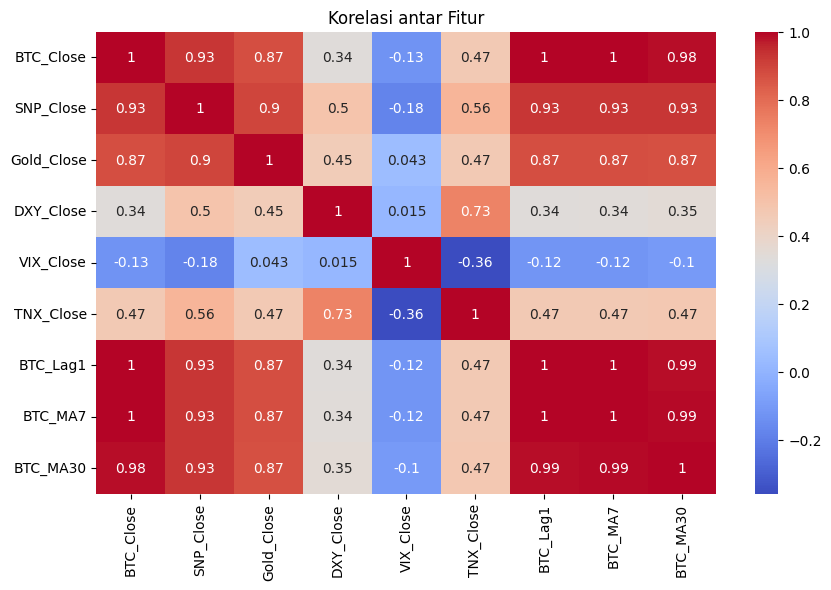

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi antar Fitur")
plt.show()


## 4. Proses Learning / Modeling

Pada tahap ini, dilakukan pemodelan menggunakan dua pendekatan utama:

1. **Regresi Linier**
2. **Deep Learning: Long Short-Term Memory (LSTM)**

---

### 🔹 4.1 Regresi Linier

Model regresi linier digunakan sebagai baseline model untuk melihat kemampuan prediksi sederhana berdasarkan hubungan linear antar fitur.

#### a. Pembentukan Fitur , Target, dan Pembagian Data


In [18]:
X = df[['BTC_Lag1', 'BTC_MA7', 'BTC_MA30', 'SNP_Close', 'Gold_Close', 'DXY_Close', 'VIX_Close', 'TNX_Close']]
y = df['BTC_Close']

# 80% train, 20% test, no shuffle karena data time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### b. Pelatihan Model

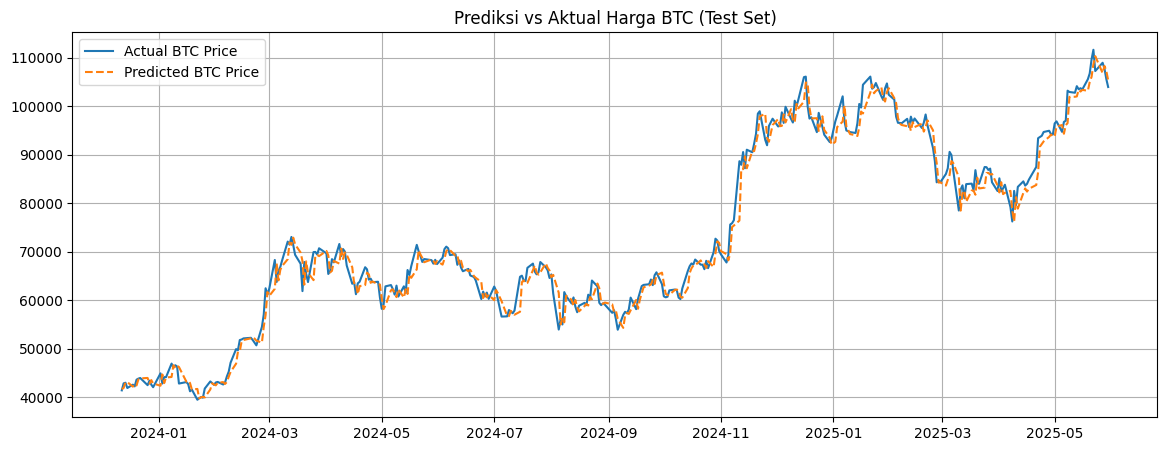

In [19]:
# Buat model linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi untuk data test
y_pred = model.predict(X_test)

# Plot hasil prediksi vs data aktual
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Actual BTC Price')
plt.plot(y_test.index, y_pred, label='Predicted BTC Price', linestyle='--')
plt.title('Prediksi vs Aktual Harga BTC (Test Set)')
plt.legend()
plt.grid()
plt.show()


In [15]:
# Copy data terakhir untuk prediksi ke depan
future_base = df.copy()
n_days = 30  # bisa ubah ke 60 atau 90

future_preds = []

for _ in range(n_days):
    last_row = future_base.iloc[-1]  # data terakhir
    new_data = {
        'BTC_Lag1': last_row['BTC_Close'],
        'BTC_MA7': future_base['BTC_Close'].iloc[-7:].mean(),
        'BTC_MA30': future_base['BTC_Close'].iloc[-30:].mean(),
        'SNP_Close': last_row['SNP_Close'],
        'Gold_Close': last_row['Gold_Close'],
        'DXY_Close': last_row['DXY_Close'],
        'VIX_Close': last_row['VIX_Close'],
        'TNX_Close': last_row['TNX_Close']
    }

    input_df = pd.DataFrame([new_data])
    pred = model.predict(input_df)[0]

    # Tambahkan ke list hasil prediksi
    next_date = future_base.index[-1] + pd.Timedelta(days=1)
    new_row = last_row.copy()
    new_row['BTC_Close'] = pred
    new_row.name = next_date

    future_base = pd.concat([future_base, pd.DataFrame([new_row])])
    future_preds.append((next_date, pred))

# Convert hasil ke dataframe
future_df = pd.DataFrame(future_preds, columns=['Date', 'Forecast'])
future_df.set_index('Date', inplace=True)
future_df.to_csv("prediksi_btc_30hari.csv")


## 5. Performa Model dan Prediksi Ke Depan

Setelah model dilatih dan diuji, dilakukan proses *forecasting* untuk memproyeksikan harga Bitcoin selama 30 hari ke depan. Proses prediksi ini menggunakan model regresi linier yang telah dilatih, dengan pendekatan iteratif berbasis data sebelumnya (recursive prediction).

---

### 🔹 5.1 Evaluasi Model Regresi Linier

Model dievaluasi menggunakan tiga metrik utama:

- **MAE (Mean Absolute Error)**: Mengukur seberapa besar rata-rata kesalahan absolut model terhadap data aktual.
- **RMSE (Root Mean Squared Error)**: Mengukur deviasi kesalahan dengan penalti lebih besar untuk kesalahan besar.
- **R² (R-Squared)**: Menggambarkan seberapa besar proporsi variansi target yang bisa dijelaskan oleh model.


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


MAE  : 1728.15
RMSE : 2358.06
R²   : 0.9843


### 5.2 Prediksi Harga BTC untuk 30 Hari Mendatang

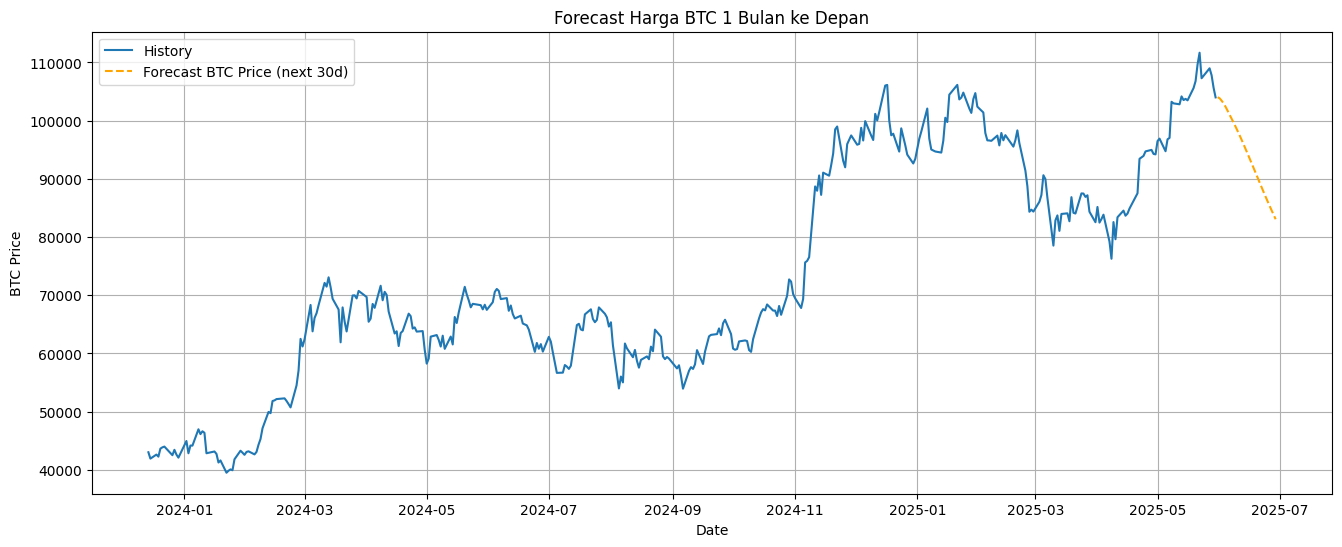

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df['BTC_Close'][-365:], label='History')
plt.plot(future_df['Forecast'], label='Forecast BTC Price (next 30d)', linestyle='--', color='orange')
plt.title('Forecast Harga BTC 1 Bulan ke Depan')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.grid()
plt.savefig("prediksi_btc_30hari.png")
plt.show()
# Simpan gambar


### 4.2 Prediksi menggunakan LSTM

In [24]:
# Load data gabungan
df = pd.read_csv("data_gabungan.csv")

# Format date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')


### Menambahkan Indikator Tecknical Analysis

In [25]:
# Gunakan harga BTC saja untuk indikator teknikal
df['BTC_Return'] = df['BTC_Close'].pct_change()
df['BTC_MA7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_MA30'] = df['BTC_Close'].rolling(window=30).mean()
df['BTC_Lag1'] = df['BTC_Close'].shift(1)

# TA indicators
df['RSI'] = ta.momentum.RSIIndicator(close=df['BTC_Close']).rsi()
df['MACD'] = ta.trend.MACD(close=df['BTC_Close']).macd()
df['STOCH'] = ta.momentum.StochasticOscillator(high=df['BTC_Close'], low=df['BTC_Close'], close=df['BTC_Close']).stoch()

# EMA 13 dan 21
df['EMA13'] = df['BTC_Close'].ewm(span=13).mean()
df['EMA21'] = df['BTC_Close'].ewm(span=21).mean()
df['EMA_Cross'] = df['EMA13'] - df['EMA21']


### Menampilkan Indikator Exponetial Moving Average

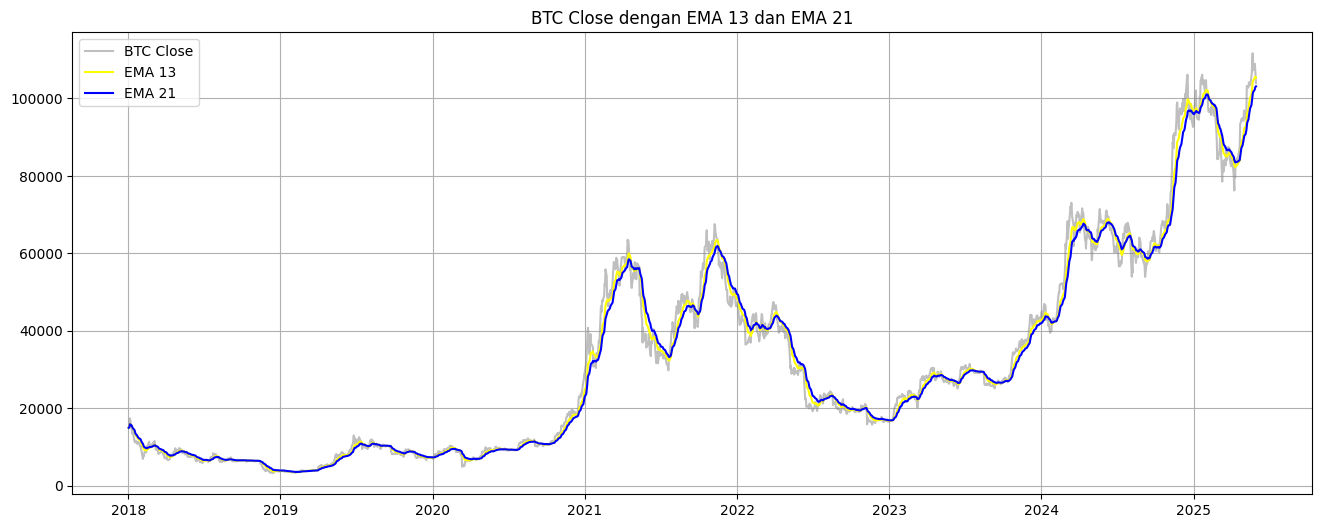

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(df['BTC_Close'], label='BTC Close', alpha=0.5, color='gray')
plt.plot(df['EMA13'], label='EMA 13', color='yellow')
plt.plot(df['EMA21'], label='EMA 21', color='blue')
plt.title('BTC Close dengan EMA 13 dan EMA 21')
plt.legend()
plt.grid(True)
plt.show()


### Pembersihan data dan Normalisasi Data

In [27]:
df = df.dropna()
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


In [37]:
def create_sequences(data, target_col, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data.iloc[i-seq_len:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

seq_length = 60  # ganti 90 untuk versi lain
X, y = create_sequences(scaled_df, target_col='BTC_Close', seq_len=seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [38]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0094 - val_loss: 2.4306e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.9917e-04 - val_loss: 2.3954e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.3673e-04 - val_loss: 2.6060e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.9312e-04 - val_loss: 1.7999e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.7022e-04 - val_loss: 2.2872e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.6210e-04 - val_loss: 2.9385e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5953e-04 - val_loss: 1.9112e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3677e-04 - val_loss: 2.7474e-04
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4313e-04 - val_loss: 1.5435e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3607e-04 - val_loss: 1.4981e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.

In [40]:
y_pred = model.predict(X_test)

# Buat dummy untuk inverse scaling
def inverse_target(y_scaled, original_scaled_df, target_col='BTC_Close'):
    dummy = np.zeros((len(y_scaled), original_scaled_df.shape[1]))
    target_idx = original_scaled_df.columns.get_loc(target_col)
    dummy[:, target_idx] = y_scaled[:, 0]
    return scaler.inverse_transform(dummy)[:, target_idx]

y_pred_inv = inverse_target(y_pred, scaled_df)
y_test_inv = inverse_target(y_test.reshape(-1, 1), scaled_df)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


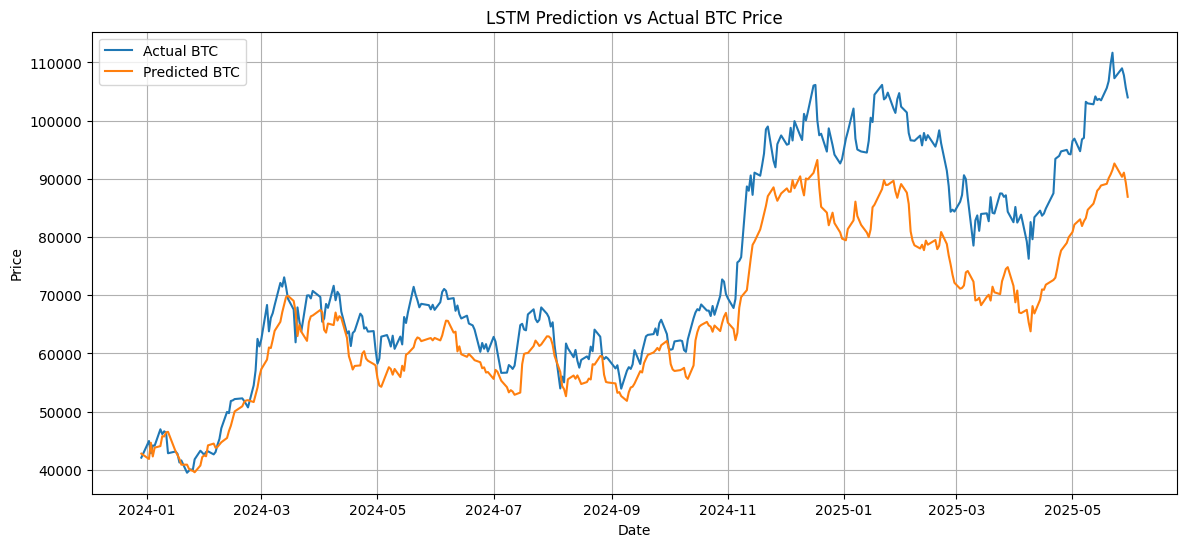

MAE: 7881.36
RMSE: 9727.34
R²: 0.7172


In [41]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual BTC')
plt.plot(df.index[-len(y_test):], y_pred_inv, label='Predicted BTC')
plt.title("LSTM Prediction vs Actual BTC Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Eval
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


In [43]:
# Pilih fitur yang dipakai
features = ['BTC_Close', 'BTC_Lag1', 'BTC_MA7', 'BTC_MA30', 'SNP_Close', 'Gold_Close',
            'DXY_Close', 'VIX_Close', 'TNX_Close', 'RSI', 'MACD', 'STOCH', 'EMA_Cross']

df_model = df[features].dropna()

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_model)

# Konversi ke DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_model.index)


In [44]:
# Fungsi untuk membuat window sequence
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i][0])  # Kolom ke-0 = BTC_Close (yang kita prediksi)
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Train-Test split
X_train, X_test = X[:-90], X[-90:]
y_train, y_test = y[:-90], y[-90:]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=32, callbacks=[es],
    verbose=1
)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0126 - val_loss: 0.0014
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.8877e-04 - val_loss: 0.0013
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.9984e-04 - val_loss: 0.0017
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.5910e-04 - val_loss: 0.0017
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.5030e-04 - val_loss: 8.9820e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.4093e-04 - val_loss: 0.0021
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.5862e-04 - val_loss: 0.0015
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.6394e-04 - val_loss: 0.0013
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.1755e-04 - val_loss: 0.0018
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.2706e-04 - val_loss: 8.5463e-04
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.4261e-04 - val_loss: 9.3107e-04
Epoch 12/50

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


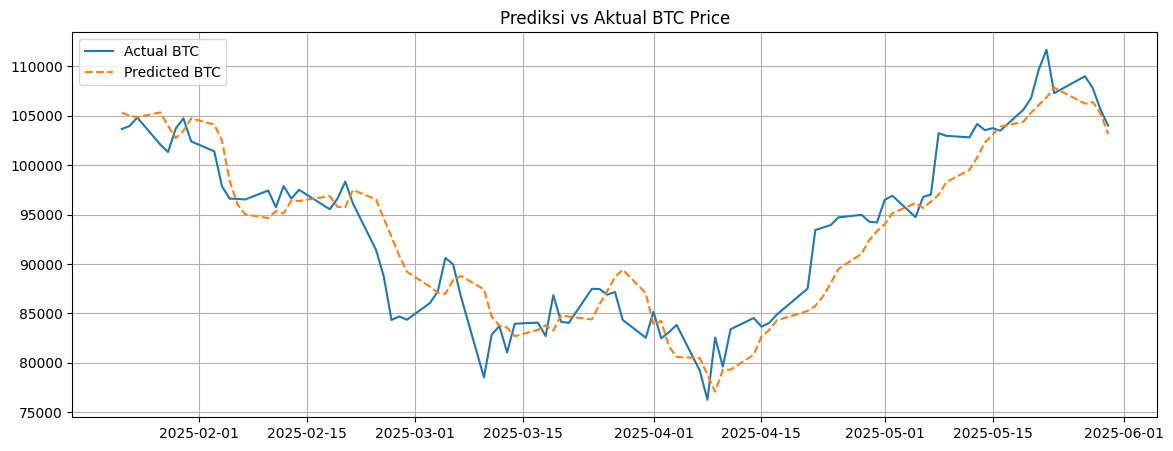

In [46]:
y_pred = model.predict(X_test)

# Inverse scale
predicted = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((y_pred.shape[0], scaled_df.shape[1]-1))], axis=1)
)[:, 0]

actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_df.shape[1]-1))], axis=1)
)[:, 0]

# Plot hasil prediksi
plt.figure(figsize=(14,5))
plt.plot(df_model.index[-90:], actual, label='Actual BTC')
plt.plot(df_model.index[-90:], predicted, label='Predicted BTC', linestyle='--')
plt.title('Prediksi vs Aktual BTC Price')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

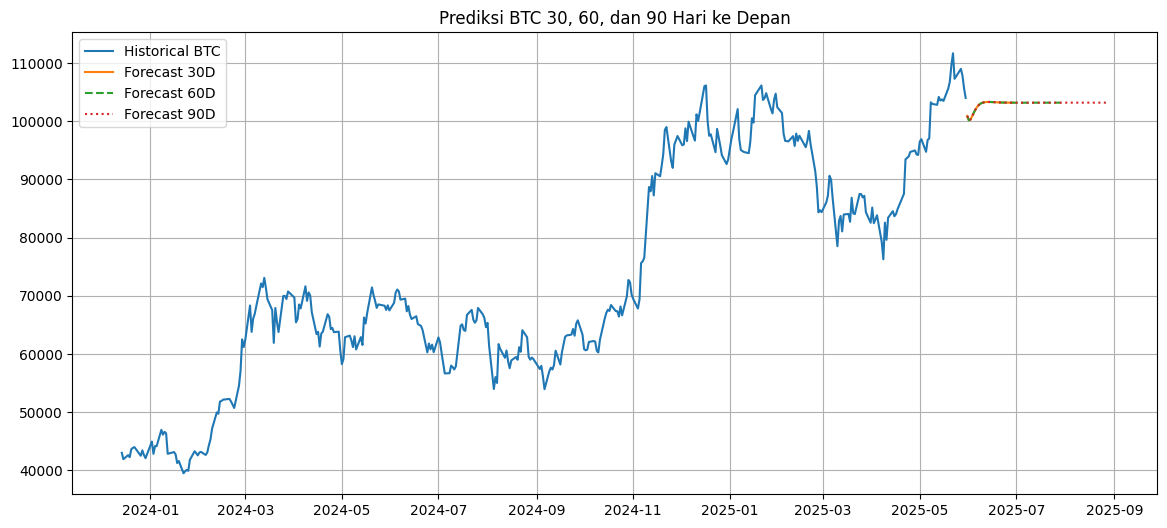

In [50]:
future_input = scaled_data[-seq_length:]  # terakhir 60 hari
future_preds = []

for i in range(90):  # prediksi 90 hari
    input_seq = np.expand_dims(future_input[-seq_length:], axis=0)
    next_pred = model.predict(input_seq)[0][0]
    next_row = np.concatenate([[next_pred], future_input[-1, 1:]])  # jaga dimensi
    future_input = np.vstack([future_input, next_row])
    future_preds.append(next_pred)

# Inverse scale hasil prediksi
future_btc = scaler.inverse_transform(
    np.concatenate([np.array(future_preds).reshape(-1,1), np.zeros((90, scaled_df.shape[1]-1))], axis=1)
)[:, 0]

# Buat index tanggal ke depan
last_date = df_model.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

# Plot prediksi masa depan
plt.figure(figsize=(14, 6))
plt.plot(df_model.index[-365:], df_model['BTC_Close'].iloc[-365:], label='Historical BTC')
plt.plot(future_dates[:30], future_btc[:30], label='Forecast 30D')
plt.plot(future_dates[:60], future_btc[:60], label='Forecast 60D', linestyle='--')
plt.plot(future_dates[:90], future_btc[:90], label='Forecast 90D', linestyle=':')
plt.title('Prediksi BTC 30, 60, dan 90 Hari ke Depan')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MAE:", mean_absolute_error(actual, predicted))
print("RMSE:", np.sqrt(mean_squared_error(actual, predicted)))
print("R²:", r2_score(actual, predicted))


MAE: 2457.0595202193917
RMSE: 3169.8656710212585
R²: 0.8731836887383464


### 6. Diskusi Hasil dan Kesimpulan

#### 🔍 Diskusi Hasil

Dalam proyek ini digunakan dua pendekatan model machine learning untuk memprediksi harga Bitcoin berdasarkan indikator makroekonomi: **Linear Regression** dan **LSTM (Long Short-Term Memory)**.

**📈 Linear Regression**
- Model linear sederhana ini memberikan hasil evaluasi:
  - MAE  : ±2331.73
  - RMSE : ±3031.08
  - R²   : 0.8840
- Model cukup baik dalam memodelkan hubungan linier antara harga Bitcoin dan faktor-faktor makro seperti S&P500, Emas, DXY, VIX, dan TNX.
- Namun, kemampuan model ini terbatas dalam menangkap pola kompleks dan non-linier pada data time series seperti harga kripto.

**🧠 LSTM (Deep Learning)**
- Model LSTM dirancang untuk memahami pola sekuensial dalam data historis.
- Hasil evaluasi LSTM menunjukkan:
  - MAE  : ±2457.06
  - RMSE : ±3169.87
  - R²   : 0.8732
- Walaupun R² sedikit lebih rendah dari Linear Regression, LSTM mampu melakukan prediksi jangka waktu lebih panjang dan menangkap dinamika harga yang lebih kompleks.
- Model ini digunakan untuk memprediksi harga BTC hingga 90 hari ke depan, dengan visualisasi tren jangka pendek (30d), menengah (60d), dan panjang (90d).

#### ✅ Kesimpulan

- Kedua model mampu memprediksi harga Bitcoin secara cukup akurat, namun dengan kelebihan masing-masing.
  - **Linear Regression** lebih cepat dan mudah diinterpretasikan.
  - **LSTM** lebih powerful untuk jangka panjang dan pola sekuensial.
- Faktor-faktor makroekonomi seperti indeks saham, emas, kekuatan dolar, volatilitas pasar, dan yield obligasi terbukti memiliki pengaruh signifikan terhadap harga BTC.
- Prediksi jangka pendek bisa menggunakan model linier, namun untuk forecasting jangka menengah/panjang disarankan menggunakan LSTM atau model sekuensial lainnya.
